# Tutorial 3: SAM (PD Mouse A)

DePass was applied to the mouse brain dataset (2,384 spatial spots) for cross-modal integration and data enhancement. This tutorial demonstrates: 
1. Spatial domain identification in mouse brain tissue using DePass.
2. Validation of data enhancement through comparative analysis of biomarker log2 fold-changes (LogFC) and spatial expression patterns.

### Preparation

In [1]:
import scanpy as sc
import torch
import random
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")
# sys.path.append('/home/jyx/DePass-main')

from DePass.utils import *
fix_seed(2024)  

# Environment configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

os.environ['R_HOME'] = '/home/jyx/anaconda3/envs/DePass/lib/R'

path = '../data/dataset_PD_Mouse_Brain_A'
os.mkdir(path) if not os.path.exists(path) else print(f"The directory '{path}' already exists.\n")

The directory '../data/dataset_PD_Mouse_Brain_A' already exists.



### Loading and Preprocessing

Load the raw count data and perform preprocessing to ensure high-quality input for model. The preprocessing methods are detailed below:
For transcriptomics and metabolomics, we filtered gene/metabolite features to retain those detected in ≥1% of cells. Top 1,000 highly variable genes (HVGs) were selected via Seurat v3 dispersion-based method. Counts were normalized per cell (total scaling to 10^4), followed by log1p transformation and z-score standardization via scanpy package.

In [ ]:
adata_omics1 = sc.read_h5ad('../data/dataset_PD_Mouse_Brain_A/adata_RNA.h5ad')
adata_omics2 = sc.read_h5ad('../data/dataset_PD_Mouse_Brain_A/adata_meta.h5ad')

preprocess_data(adata=adata_omics1,modality='rna')
preprocess_data(adata=adata_omics2,modality='metabolite')

adata_omics1.obsm['input_feat'] = adata_omics1.obsm['X_norm'].copy()
adata_omics2.obsm['input_feat'] = adata_omics2.obsm['X_norm'].copy()
data = {'rna': adata_omics1, 'metabolite': adata_omics2}

### Training the model

In [ ]:
from DePass.model import DePass
model = DePass(data, data_type='spatial',device=device)
output = model.train()

[Config]
Modalities: 2 | Data: spatial | Device: NVIDIA GeForce RTX 4090 

[Initializing]
Graph Construction : Running...
Graph Construction : Done!
Data Enhancement : Running...
Data Enhancement : Done!

[Training]
Model training starts...


100%|██████████| 200/200 [00:02<00:00, 81.59it/s] 

Model training finished!



In [ ]:
adata = adata_omics1.copy()
adata.obsm['DePass'] = model.embedding
adata.obsm['alpha'] = model.alpha 

### Detect spatial domain 

After the model is trained, we use the integrated representation for cluster analysis. Here we provide three optional clustering tools, including **mclust**, **leiden**, and **kmeans**. We recommend using the **mclust** algorithm for clustering and specifying the number of target clusters. In this example, we set the number of clusters to 11 and use PCA for dimensionality reduction by setting `use_pca=True`.  The clustering results are stored in the `adata` object under the key `'DePass'`. 

For visualization, we perform **spatial visualization of regions** using **matplotlib**, where colors correspond to the cluster assignments. 



In [ ]:
from DePass.utils import *
clustering(adata=adata,n_clusters=11,key='DePass',add_key='DePass',method='mclust',use_pca=True)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


In [3]:
from DePass.utils import super_eval
import pandas as pd
re = super_eval(adata.obs['DePass'],adata.obs['Y'])
print(re)
df = pd.DataFrame(list(re.items()), columns=['metric', 'Value']).to_csv(path + '/re.csv', sep='\t', index=True, float_format='%.6f')


{'AMI': 0.7075564659694622, 'NMI': 0.710627009526667, 'ARI': 0.576198096064716, 'Homogeneity': 0.7551834049333622, 'V-measure': 0.7106270095266671, 'Mutual Information': 1.4865456963849457}


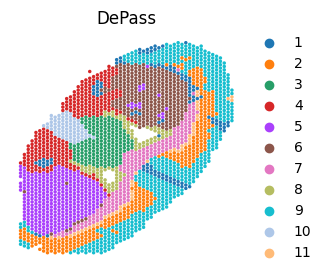

In [4]:
from DePass.analyze_utils import plot_spatial

plot_spatial(
    adata,
    color='DePass',
    save_path=path,
    save_name='DePass',
    title="DePass",
    s=25,
    dpi=300,
    format='pdf',
    show=True,
)


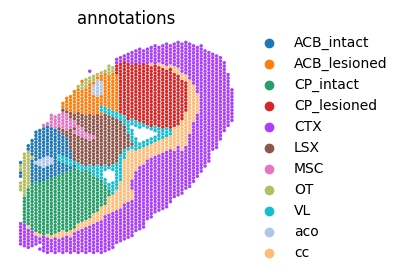

In [5]:
from DePass.analyze_utils import plot_spatial
plot_spatial(
    adata,
    color='annotations',
    save_path=path,
    save_name='annotations',
    title="annotations",
    s=25,
    dpi=300,
    format='pdf',
    show=True,
)


In [ ]:
adata.write(path+'/adata.h5ad')